In [263]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model 1: Basic GP

In [264]:
modeWeightsOrig = pd.read_csv(r'Mode_Weight_Full_Cohort.csv',index_col='Mesh_ID')
print(modeWeightsOrig)

               Mode1      Mode2      Mode3      Mode4      Mode5      Mode6  \
Mesh_ID                                                                       
1         -26.526282 -21.987510  45.298672   6.964297   1.264487 -14.710058   
2         -16.902798  23.644504  19.452896 -24.329813 -25.447350  20.415574   
3          14.528402  16.328970  -5.269040  31.653975   7.173021  17.494031   
4         -15.076964  28.889168   8.644859   4.758042   1.301095   5.983310   
5          -3.839848 -47.723637   7.042452  -4.914959  -4.014415  20.366371   
6          18.372208 -13.173184 -10.191443 -24.148353   5.156296  -5.613573   
7         -34.355273 -16.804885  -6.838693 -12.785964   5.546781 -11.206395   
8         -25.433101   7.377060  16.518874  10.553323  20.454561  -3.834116   
11         80.119501   6.505305   4.707190  18.693887 -17.988034  -9.927770   
12         51.114176 -25.099497  -6.603593  -1.858095   2.108524   6.369323   
13          2.227391  21.550335  14.556385 -15.90453

In [265]:
modelOutputOrig = pd.read_csv(r'simulation_output_Full_Cohort.csv',index_col=0)
print(modelOutputOrig)

            EDV_LV  Myo_vol_LV  ESV_LV   SV_LV    V1_LV     EF1_LV  \
Mesh_ID                                                              
1          119.650  163.305835  55.614  64.036   90.248  24.573339   
2          128.603  202.159662  51.027  77.576   98.402  23.483900   
3          152.279  154.973015  65.778  86.501  110.147  27.667636   
4          145.034  199.463111  57.180  87.854  105.630  27.168802   
5          118.599   91.976665  55.855  62.744   94.714  20.139293   
6           85.968  109.660211  40.184  45.784   68.640  20.156337   
7          113.130   94.998853  49.677  63.453   84.963  24.897905   
8          142.547  135.194656  64.998  77.549  107.610  24.509109   
11         140.874  140.723552  65.420  75.454  107.909  23.400344   
12         101.382  101.575101  45.137  56.245   77.413  23.642264   
13         139.551  152.838953  59.194  80.357  103.644  25.730378   
14         176.987  167.319878  79.883  97.104  129.387  26.894631   
15         103.318  

In [266]:
def modeNorm(modeWeightsOrig):
    modeMax=np.max(modeWeightsOrig,axis=0)
    modeMean = np.mean(modeWeightsOrig,axis=0)
    modeStd = np.std(modeWeightsOrig,axis=0)
    #modeMin = np.min(modeWeightsOrig,axis=0)
    modeNorm = (modeWeightsOrig-modeMean)/(modeStd)
    #modeNorm = modeWeightsOrig/modeMax
    modeWeights=modeNorm
    return modeWeights

In [267]:
modeWeights = modeNorm(modeWeightsOrig)

In [268]:
def outputNorm(modelOutputOrig):
    outMax = np.max(modelOutputOrig,axis=0)
    outMean = np.mean(modelOutputOrig,axis=0)
    outStd = np.std(modelOutputOrig,axis=0)
    modelOutput = (modelOutputOrig-outMean)/outStd.T
    return modelOutput

In [269]:
modelOutput=outputNorm(modelOutputOrig)

In [270]:
modelOutput.shape

(51, 29)

In [271]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=18))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [272]:
class ZeroMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ZeroMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=18))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [273]:
def GPEnsemble(modeWeights,modelOutput,zeroMean=False):
    models = []
    likelihoods = []
    MSE = []
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        print(i)
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood())
        if zeroMean==False:
            models.append(ExactGPModel(torch.tensor(modeWeights.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        else:
            models.append(ZeroMeanGPModel(torch.tensor(modeWeights.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 100


        # Find optimal model hyperparameters
        models[i].train()
        likelihoods[i].train()
        X=torch.tensor(modeWeights.values)
        Y=torch.tensor(modelOutput.iloc[:,i].values).squeeze()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(models[i] .parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoods[i], models[i] )


        for j in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = models[i](X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    j + 1, training_iter, loss.item(),
            #    models[i].covar_module.base_kernel.lengthscale.item(),
            #    models[i].likelihood.noise.item()
            #))
            optimizer.step()
    return models, likelihoods

In [274]:
def GPEnsemblePredict(models,modelOutputOrig,inputVals):
    outMax = np.max(modelOutputOrig,axis=0)
    outMean = np.mean(modelOutputOrig,axis=0)
    outStd = np.std(modelOutputOrig,axis=0)
    #modelOutput = (modelOutputOrig-outMean)/outStd.T
    nMod = modelOutputOrig.shape[1]
    prediction=[]
    for i in range(nMod):
        models[i].eval()
        out = outStd[i].T*(models[i](inputVals).mean)+outMean[i]
        prediction.append(out)
    return prediction

In [296]:
def LRGPEnsemblePredict(linearModel,models,modelOutputOrig,inputVals):
    outMax = np.max(modelOutputOrig,axis=0)
    outMean = np.mean(modelOutputOrig,axis=0)
    outStd = np.std(modelOutputOrig,axis=0)
    #modelOutput = (modelOutputOrig-outMean)/outStd.T
    nMod = modelOutputOrig.shape[1]
    
    y_predictedSens = linearModel.predict(np.hstack((inputVals)))
    
    prediction=[]
    for i in range(nMod):
        models[i].eval()
        out = outStd[i]*(torch.tensor([y_predictedSens[:,i]])+models[i](torch.tensor([np.hstack((inputVals))])).mean)+outMean[i]
        prediction.append(out)
    return prediction



In [276]:
models, likelihoods = GPEnsemble(modeWeights,modelOutput)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [277]:
boundsMaxMin = []
for i in range(9):
    boundsMaxMin.append([np.min(modelOutput.iloc[:,i]),np.max(modelOutput.iloc[:,i])])
    print(boundsMaxMin[i])

[-2.135066711969309, 2.5723760569742447]
[-1.7816859985352045, 3.420199246101512]
[-2.0347305897263395, 2.7059668247552593]
[-2.4434532220408016, 2.479487112232864]
[-1.9718670855520848, 2.5128201118171756]
[-2.8281183372442116, 1.943766362865134]
[-2.0884608282256196, 2.8270081794557047]
[-2.085090039650264, 2.239950838351076]
[-2.0509404500913355, 2.397909895364182]


In [278]:
boundsSTD = []
for i in range(9):
    boundsSTD.append([np.mean(modelOutput.iloc[:,i])-3*np.std(modelOutput.iloc[:,i]),np.max(modelOutput.iloc[:,i])+3*np.std(modelOutput.iloc[:,i])])

In [279]:
boundsSTD

[[-3.0000000000000004, 5.572376056974244],
 [-3.0, 6.420199246101511],
 [-2.9999999999999996, 5.705966824755258],
 [-3.0000000000000004, 5.479487112232864],
 [-3.0000000000000004, 5.512820111817176],
 [-3.0000000000000018, 4.943766362865134],
 [-3.0000000000000013, 5.827008179455705],
 [-3.0000000000000013, 5.239950838351076],
 [-3.0000000000000053, 5.397909895364183]]

In [280]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 9,
    'names': ['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4','Mode 5','Mode 6', 'Mode 7', 'Mode 8', 'Mode 9'],
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 2048)

data1 = torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])
Ymean=GPEnsemblePredict(models,modelOutputOrig,data1)
# Run model (example)
#outMean = np.mean(modelOutputOrig,axis=0)
#outStd = np.std(modelOutputOrig,axis=0)
#nMod = modelOutput.shape[1]
#Ymean=[]
#for j in range(nMod):
#    models[j].eval()
#    #Ymean.append(np.zeros([param_values.shape[0]]))
#    Ymean.append(outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean+outMean[j])

    

C:\Users\chris\AppData\Local\Temp\ipykernel_25432\230767710.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048)


In [281]:
Ymean[0]-YmeanTest[0]

tensor([[-2.7253, -2.6705, -4.4978,  ...,  1.4370,  0.9093,  1.2564]],
       dtype=torch.float64, grad_fn=<SubBackward0>)

In [282]:
YmeanTest

[tensor([[141.7925, 138.1938, 171.6355,  ..., 127.5372, 140.7022, 128.5216]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[155.3495, 149.7036, 215.7895,  ..., 159.2151, 145.9809, 157.2676]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[59.7012, 58.9961, 69.5887,  ..., 51.2886, 61.4288, 52.7457]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[ 81.8333,  79.0127, 101.3738,  ...,  76.4150,  79.4824,  75.9131]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[102.3964, 101.1112, 122.0301,  ...,  92.1403, 104.4476,  93.9429]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[27.4373, 26.6022, 28.3624,  ..., 27.6084, 25.7808, 26.7303]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[2.6091, 2.5396, 2.7190,  ..., 2.9468, 2.6877, 2.9113]],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[-2.0106, -2.0180, -2.0667,  ..., -2.0365, -1.8946, -1.9559]],
        dtype=torch.float64,

In [283]:
Si = []
nMod = modelOutput.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.022247  0.001448
Mode 2  0.408328  0.020850
Mode 3  0.177444  0.011965
Mode 4  0.279085  0.017459
Mode 5  0.009184  0.000553
Mode 6  0.013972  0.000994
Mode 7  0.006589  0.000471
Mode 8  0.001042  0.000078
Mode 9  0.090499  0.005614
              S1   S1_conf
Mode 1  0.021868  0.008990
Mode 2  0.403449  0.034113
Mode 3  0.174878  0.023605
Mode 4  0.275363  0.027576
Mode 5  0.009346  0.006190
Mode 6  0.009790  0.007598
Mode 7  0.006448  0.005294
Mode 8  0.000710  0.001886
Mode 9  0.089321  0.018009
                        S2   S2_conf
(Mode 1, Mode 2)  0.000226  0.015615
(Mode 1, Mode 3)  0.000188  0.014258
(Mode 1, Mode 4)  0.000420  0.015747
(Mode 1, Mode 5)  0.000328  0.013599
(Mode 1, Mode 6)  0.000442  0.013537
(Mode 1, Mode 7)  0.000308  0.013512
(Mode 1, Mode 8)  0.000326  0.013318
(Mode 1, Mode 9)  0.000293  0.012630
(Mode 2, Mode 3)  0.000288  0.053442
(Mode 2, Mode 4)  0.001317  0.054776
(Mode 2, Mode 5) -0.000094  0.046050
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.461806  0.028687
Mode 2  0.298442  0.018807
Mode 3  0.003598  0.000304
Mode 4  0.087428  0.006396
Mode 5  0.008933  0.000604
Mode 6  0.019384  0.001419
Mode 7  0.010636  0.000892
Mode 8  0.063778  0.004706
Mode 9  0.095727  0.007177
              S1   S1_conf
Mode 1  0.429854  0.040145
Mode 2  0.256996  0.031503
Mode 3  0.002665  0.003795
Mode 4  0.083424  0.017340
Mode 5  0.008611  0.005957
Mode 6  0.017880  0.007762
Mode 7  0.008539  0.006355
Mode 8  0.061973  0.015218
Mode 9  0.085297  0.017416
                        S2   S2_conf
(Mode 1, Mode 2)  0.025827  0.059618
(Mode 1, Mode 3)  0.000335  0.047386
(Mode 1, Mode 4) -0.000698  0.049746
(Mode 1, Mode 5) -0.000103  0.045717
(Mode 1, Mode 6) -0.000185  0.048733
(Mode 1, Mode 7)  0.000850  0.047561
(Mode 1, Mode 8)  0.001328  0.049920
(Mode 1, Mode 9)  0.002083  0.054365
(Mode 2, Mode 3) -0.005084  0.044683
(Mode 2, Mode 4) -0.001822  0.046213
(Mode 2, Mode 5) -0.005222  0.044129
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.000701  0.000230
Mode 2  0.058862  0.020392
Mode 3  0.316880  0.077684
Mode 4  0.037168  0.013085
Mode 5  0.143334  0.037103
Mode 6  0.000494  0.000139
Mode 7  0.903017  0.097683
Mode 8  0.142378  0.024648
Mode 9  0.042418  0.011610
              S1   S1_conf
Mode 1 -0.001260  0.001570
Mode 2  0.008370  0.015283
Mode 3  0.038308  0.036485
Mode 4  0.000983  0.010451
Mode 5  0.025034  0.025010
Mode 6 -0.000291  0.001640
Mode 7  0.417139  0.090426
Mode 8  0.015384  0.019682
Mode 9  0.010057  0.015659
                        S2   S2_conf
(Mode 1, Mode 2)  0.001972  0.002699
(Mode 1, Mode 3)  0.001588  0.002392
(Mode 1, Mode 4)  0.002177  0.002526
(Mode 1, Mode 5)  0.001949  0.002661
(Mode 1, Mode 6)  0.001884  0.002627
(Mode 1, Mode 7) -0.001863  0.005409
(Mode 1, Mode 8)  0.001412  0.003108
(Mode 1, Mode 9)  0.002012  0.002800
(Mode 2, Mode 3) -0.011478  0.022139
(Mode 2, Mode 4) -0.018417  0.022314
(Mode 2, Mode 5) -0.013494  0.023996
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.034080  0.002324
Mode 2  0.670301  0.036136
Mode 3  0.172065  0.011519
Mode 4  0.119763  0.008183
Mode 5  0.002727  0.000189
Mode 6  0.013199  0.001141
Mode 7  0.004142  0.000282
Mode 8  0.000067  0.000005
Mode 9  0.002025  0.000153
              S1   S1_conf
Mode 1  0.033339  0.010326
Mode 2  0.654472  0.042701
Mode 3  0.166640  0.026441
Mode 4  0.117099  0.022914
Mode 5  0.003021  0.003139
Mode 6  0.004438  0.007411
Mode 7  0.004106  0.004071
Mode 8  0.000137  0.000453
Mode 9  0.001698  0.002798
                        S2   S2_conf
(Mode 1, Mode 2)  0.000453  0.018867
(Mode 1, Mode 3) -0.000329  0.017684
(Mode 1, Mode 4) -0.000079  0.015022
(Mode 1, Mode 5) -0.000181  0.014994
(Mode 1, Mode 6) -0.000030  0.015325
(Mode 1, Mode 7) -0.000299  0.015162
(Mode 1, Mode 8) -0.000184  0.014940
(Mode 1, Mode 9) -0.000205  0.014964
(Mode 2, Mode 3)  0.003251  0.056405
(Mode 2, Mode 4)  0.000771  0.050974
(Mode 2, Mode 5) -0.002031  0.050294
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.039314  0.002660
Mode 2  0.693163  0.041523
Mode 3  0.115292  0.007111
Mode 4  0.151348  0.010109
Mode 5  0.000145  0.000015
Mode 6  0.000452  0.000038
Mode 7  0.000573  0.000046
Mode 8  0.004453  0.000282
Mode 9  0.000654  0.000047
              S1   S1_conf
Mode 1  0.038555  0.011574
Mode 2  0.686336  0.049126
Mode 3  0.113158  0.018748
Mode 4  0.148470  0.020641
Mode 5  0.000553  0.000756
Mode 6  0.000505  0.001298
Mode 7  0.000499  0.001595
Mode 8  0.004400  0.003700
Mode 9  0.000596  0.001546
                        S2   S2_conf
(Mode 1, Mode 2)  0.000523  0.020711
(Mode 1, Mode 3) -0.000022  0.018284
(Mode 1, Mode 4)  0.000337  0.017370
(Mode 1, Mode 5)  0.000129  0.016633
(Mode 1, Mode 6)  0.000150  0.016643
(Mode 1, Mode 7)  0.000101  0.016560
(Mode 1, Mode 8)  0.000158  0.016618
(Mode 1, Mode 9)  0.000147  0.016688
(Mode 2, Mode 3)  0.001851  0.060719
(Mode 2, Mode 4)  0.001748  0.062235
(Mode 2, Mode 5) -0.000718  0.055003
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.010717  0.010040
Mode 2  0.015440  0.011929
Mode 3  0.238888  0.241089
Mode 4  0.000769  0.000567
Mode 5  0.494964  0.335063
Mode 6  0.000733  0.000598
Mode 7  0.981809  0.418820
Mode 8  0.834870  0.341127
Mode 9  0.009954  0.009708
              S1   S1_conf
Mode 1 -0.000285  0.000695
Mode 2  0.011367  0.019716
Mode 3  0.027726  0.045700
Mode 4  0.000973  0.001519
Mode 5  0.044923  0.076335
Mode 6  0.001281  0.002120
Mode 7  0.163502  0.175660
Mode 8  0.088773  0.118890
Mode 9  0.001148  0.001221
                        S2   S2_conf
(Mode 1, Mode 2) -0.000603  0.002432
(Mode 1, Mode 3) -0.000516  0.001961
(Mode 1, Mode 4) -0.000667  0.002386
(Mode 1, Mode 5) -0.001279  0.003755
(Mode 1, Mode 6) -0.000668  0.002389
(Mode 1, Mode 7) -0.008199  0.011375
(Mode 1, Mode 8)  0.000255  0.029098
(Mode 1, Mode 9) -0.000709  0.002417
(Mode 2, Mode 3) -0.012857  0.019222
(Mode 2, Mode 4) -0.012263  0.018219
(Mode 2, Mode 5) -0.013905  0.020156
(Mode 2, Mode 6)

# Model 2: Linear regression + Zero Mean GP

In [284]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# generate random data-set

# sckit-learn implementation

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(modeWeights, modelOutput)
# Predict
y_predicted = regression_model.predict(modeWeights)

# model evaluation
rmse = mean_squared_error(modelOutput, y_predicted)
r2 = r2_score(modelOutput, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)


Slope: [[-1.54021589e-01  5.26176805e-01  4.17042799e-01  5.39143927e-01
  -1.09621406e-01  1.52498636e-02 -5.76630938e-02 -4.77345391e-02
  -3.48296527e-01  3.61466431e-02 -2.43841516e-02  3.96034226e-02
  -5.36768588e-02 -1.26329919e-01 -6.94980233e-02  3.14869257e-03
   1.19471093e-02 -6.49790700e-02]
 [-9.07731209e-02  8.00939349e-01  3.83192485e-01  5.35958184e-02
  -1.01739602e-01  8.98668944e-02 -2.47704147e-01  5.01152561e-02
   2.21716228e-01  1.06651020e-01  1.85600746e-05  3.69214364e-02
  -9.43340531e-02  3.05087488e-02  1.70157534e-02  3.68747010e-03
  -9.13405184e-02 -6.95339609e-04]
 [-8.31191016e-02  3.36359536e-01  4.20392750e-01  6.11489099e-01
  -1.25603466e-01 -4.53733161e-02 -5.62885097e-03 -1.15411668e-01
  -4.38773588e-01  1.27615955e-03 -4.56286778e-02  5.15934663e-02
  -6.44933969e-02 -1.00746004e-01 -6.66996083e-02  4.85151626e-02
   1.58931055e-02 -1.14531945e-01]
 [-2.03469900e-01  6.50605738e-01  3.85065482e-01  4.40049221e-01
  -8.83924406e-02  6.56633485e

In [285]:
modelOutputAdjusted = modelOutput - y_predicted

In [286]:
modelsZM, likelihoodsZM = GPEnsemble(modeWeights,modelOutputAdjusted,zeroMean=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [298]:
YmeanSens = LRGPEnsemblePredict(regression_model,modelsZM,modelOutputOrig,data1)

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [299]:
data1.squeeze().shape

torch.Size([40960, 18])

In [300]:
SiZM = []
nMod = modelOutput.shape[1]
for i in range(nMod):
    SiZM.append(sobol.analyze(problem, YmeanSens[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.023242  0.001487
Mode 2  0.364984  0.022172
Mode 3  0.180076  0.010303
Mode 4  0.309780  0.018941
Mode 5  0.010532  0.000682
Mode 6  0.000225  0.000015
Mode 7  0.004099  0.000271
Mode 8  0.001730  0.000103
Mode 9  0.105540  0.006838
              S1   S1_conf
Mode 1  0.023247  0.008283
Mode 2  0.364837  0.031866
Mode 3  0.180021  0.026089
Mode 4  0.309733  0.033370
Mode 5  0.010538  0.006366
Mode 6  0.000236  0.000926
Mode 7  0.004094  0.004166
Mode 8  0.001723  0.002720
Mode 9  0.105586  0.020089
                        S2   S2_conf
(Mode 1, Mode 2)  0.000033  0.014368
(Mode 1, Mode 3)  0.000055  0.014006
(Mode 1, Mode 4)  0.000054  0.013328
(Mode 1, Mode 5)  0.000057  0.012067
(Mode 1, Mode 6)  0.000058  0.011999
(Mode 1, Mode 7)  0.000056  0.012022
(Mode 1, Mode 8)  0.000051  0.011974
(Mode 1, Mode 9) -0.000014  0.012297
(Mode 2, Mode 3) -0.000001  0.050356
(Mode 2, Mode 4)  0.000042  0.050494
(Mode 2, Mode 5) -0.000091  0.045894
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.296833  0.018550
Mode 2  0.414971  0.023931
Mode 3  0.009092  0.000633
Mode 4  0.142458  0.009050
Mode 5  0.027400  0.001812
Mode 6  0.005686  0.000470
Mode 7  0.003989  0.000283
Mode 8  0.052661  0.003635
Mode 9  0.050147  0.003465
              S1   S1_conf
Mode 1  0.294134  0.030700
Mode 2  0.414061  0.034063
Mode 3  0.009133  0.005690
Mode 4  0.141912  0.022117
Mode 5  0.027305  0.009504
Mode 6  0.005889  0.005211
Mode 7  0.003495  0.003662
Mode 8  0.052894  0.013929
Mode 9  0.049119  0.013021
                        S2   S2_conf
(Mode 1, Mode 2)  0.001366  0.047699
(Mode 1, Mode 3)  0.000138  0.038652
(Mode 1, Mode 4)  0.000106  0.044952
(Mode 1, Mode 5)  0.000299  0.040464
(Mode 1, Mode 6)  0.000073  0.039941
(Mode 1, Mode 7)  0.000295  0.039866
(Mode 1, Mode 8) -0.000211  0.041176
(Mode 1, Mode 9)  0.000305  0.042585
(Mode 2, Mode 3) -0.000809  0.045187
(Mode 2, Mode 4)  0.000189  0.053994
(Mode 2, Mode 5) -0.000901  0.046924
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.000754  0.000047
Mode 2  0.132877  0.008447
Mode 3  0.358603  0.021666
Mode 4  0.103133  0.007145
Mode 5  0.095995  0.006824
Mode 6  0.003748  0.000248
Mode 7  0.014019  0.001060
Mode 8  0.000168  0.000053
Mode 9  0.291748  0.018874
              S1   S1_conf
Mode 1  0.000738  0.001446
Mode 2  0.132837  0.022411
Mode 3  0.358490  0.034082
Mode 4  0.103179  0.022801
Mode 5  0.095923  0.018655
Mode 6  0.003755  0.003922
Mode 7  0.014468  0.006848
Mode 8  0.000230  0.000731
Mode 9  0.291501  0.034157
                            S2   S2_conf
(Mode 1, Mode 2) -1.823499e-05  0.002249
(Mode 1, Mode 3) -5.770915e-06  0.002725
(Mode 1, Mode 4) -1.747040e-05  0.002192
(Mode 1, Mode 5) -2.057639e-05  0.002422
(Mode 1, Mode 6) -1.919212e-05  0.002277
(Mode 1, Mode 7) -1.640171e-05  0.002364
(Mode 1, Mode 8) -5.880883e-07  0.002294
(Mode 1, Mode 9) -1.880028e-07  0.002480
(Mode 2, Mode 3) -2.329878e-05  0.034455
(Mode 2, Mode 4) -8.003565e-06  0.031699
(Mode 2, 

              ST   ST_conf
Mode 1  0.041958  0.002443
Mode 2  0.567785  0.029124
Mode 3  0.228967  0.013425
Mode 4  0.125814  0.007529
Mode 5  0.001653  0.000109
Mode 6  0.005844  0.000380
Mode 7  0.006842  0.000435
Mode 8  0.000256  0.000019
Mode 9  0.021251  0.001290
              S1   S1_conf
Mode 1  0.041936  0.012439
Mode 2  0.567407  0.040515
Mode 3  0.228811  0.029397
Mode 4  0.125905  0.022237
Mode 5  0.001709  0.002600
Mode 6  0.005555  0.004704
Mode 7  0.006851  0.005528
Mode 8  0.000209  0.000816
Mode 9  0.020885  0.008646
                        S2   S2_conf
(Mode 1, Mode 2) -0.000120  0.019998
(Mode 1, Mode 3) -0.000050  0.017177
(Mode 1, Mode 4) -0.000089  0.017903
(Mode 1, Mode 5) -0.000083  0.015732
(Mode 1, Mode 6) -0.000045  0.015776
(Mode 1, Mode 7) -0.000080  0.015866
(Mode 1, Mode 8) -0.000058  0.015815
(Mode 1, Mode 9)  0.000036  0.016716
(Mode 2, Mode 3)  0.000133  0.059602
(Mode 2, Mode 4) -0.000083  0.059215
(Mode 2, Mode 5) -0.000003  0.050902
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.051891  0.003115
Mode 2  0.589440  0.031877
Mode 3  0.183249  0.011328
Mode 4  0.146596  0.009411
Mode 5  0.000019  0.000001
Mode 6  0.006348  0.000403
Mode 7  0.001926  0.000125
Mode 8  0.000888  0.000057
Mode 9  0.020475  0.001384
              S1   S1_conf
Mode 1  0.051919  0.011837
Mode 2  0.588569  0.040433
Mode 3  0.183019  0.022512
Mode 4  0.146764  0.023902
Mode 5  0.000054  0.000285
Mode 6  0.006122  0.004776
Mode 7  0.001923  0.002802
Mode 8  0.000780  0.001934
Mode 9  0.019829  0.008204
                        S2   S2_conf
(Mode 1, Mode 2) -0.000204  0.021453
(Mode 1, Mode 3) -0.000101  0.018256
(Mode 1, Mode 4) -0.000085  0.018591
(Mode 1, Mode 5) -0.000168  0.016564
(Mode 1, Mode 6) -0.000135  0.016240
(Mode 1, Mode 7) -0.000164  0.016567
(Mode 1, Mode 8) -0.000116  0.016534
(Mode 1, Mode 9) -0.000024  0.017067
(Mode 2, Mode 3)  0.000160  0.061670
(Mode 2, Mode 4) -0.000342  0.059461
(Mode 2, Mode 5)  0.000018  0.052856
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.062393  0.004484
Mode 2  0.222201  0.014153
Mode 3  0.019423  0.001340
Mode 4  0.002538  0.000173
Mode 5  0.229759  0.015063
Mode 6  0.018242  0.001005
Mode 7  0.008275  0.001260
Mode 8  0.015862  0.001410
Mode 9  0.428345  0.028908
              S1   S1_conf
Mode 1  0.063017  0.015982
Mode 2  0.221753  0.024928
Mode 3  0.020707  0.009131
Mode 4  0.002674  0.002899
Mode 5  0.229100  0.024184
Mode 6  0.018267  0.009203
Mode 7  0.008615  0.005623
Mode 8  0.017851  0.007414
Mode 9  0.427657  0.036608
                            S2   S2_conf
(Mode 1, Mode 2)  1.779929e-04  0.024538
(Mode 1, Mode 3)  2.443706e-04  0.021763
(Mode 1, Mode 4)  2.027130e-04  0.021726
(Mode 1, Mode 5)  1.716735e-04  0.025060
(Mode 1, Mode 6)  1.963681e-04  0.021677
(Mode 1, Mode 7)  1.137708e-04  0.021974
(Mode 1, Mode 8) -4.661634e-04  0.021800
(Mode 1, Mode 9) -1.436716e-04  0.027945
(Mode 2, Mode 3)  2.838267e-04  0.034358
(Mode 2, Mode 4)  2.673482e-04  0.034521
(Mode 2, 

In [301]:
SiZM_first=np.zeros((9,nMod))
SiZM_total=np.zeros((9,nMod))
Si_first=np.zeros((9,nMod))
Si_total=np.zeros((9,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = SiZM[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

## Linear Regression + GP

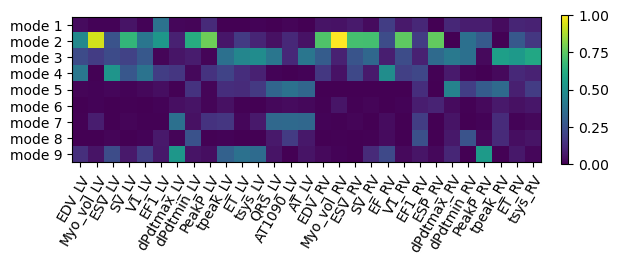

In [302]:
modes = ["mode 1", "mode 2", "mode 3", "mode 4",
              "mode 5", "mode 6", "mode 7", "mode 8", "mode 9"]
outputs = list(modelOutput.columns)

fig, ax = plt.subplots()
im = ax.imshow(SiZM_first/np.max(SiZM_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [303]:
SiZM_first[:,2]

array([0.00587464, 0.20096181, 0.17819569, 0.40760783, 0.01364368,
       0.00106255, 0.00054624, 0.0102397 , 0.18112545])

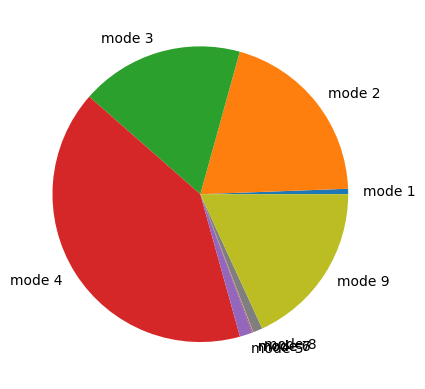

In [304]:
fig, ax = plt.subplots()
ax.pie(SiZM_first[:,2]/np.max(SiZM_first[:,2]), labels=modes);


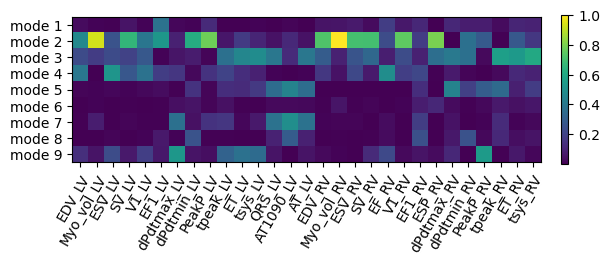

In [305]:
fig, ax = plt.subplots()
im = ax.imshow(SiZM_total/np.max(SiZM_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.colorbar(im,fraction=0.015, pad=0.04)

## Basic GP

In [306]:
np.max(SiZM_total)

0.7836126460541287

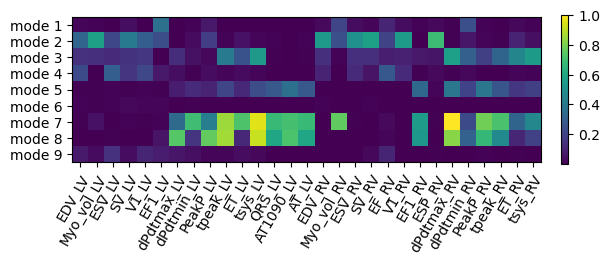

In [307]:
fig, ax = plt.subplots()
im = ax.imshow(Si_total/np.max(Si_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [308]:
Si_first[:,2]

array([0.00352165, 0.2641183 , 0.15177907, 0.3667912 , 0.01141664,
       0.00728365, 0.00275996, 0.00704114, 0.17517344])

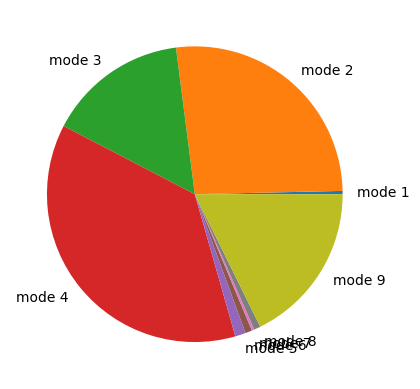

In [309]:
fig, ax = plt.subplots()
ax.pie(Si_first[:,2]/np.max(Si_first[:,2]), labels=modes);


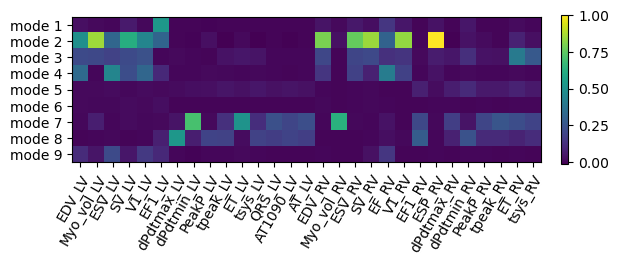

In [310]:
fig, ax = plt.subplots()
im = ax.imshow(Si_first/np.max(Si_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Leave one out MSE

In [253]:
import random

In [254]:
def standardise(data,mean,std):
    dataStandard = (data-mean)/std.T
    return dataStandard

In [255]:
def EnsembleMSE(models,modelInput,modelOutput):
    MSE = np.zeros(outputTestNorm.shape[1])
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        models[i].eval()
        
        MSE[i] = (((outStd[i]*models[i](torch.tensor([modelInput.values])).mean-outStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [256]:
def LREnsembleMSE(GPmodels,LRModel,modelInput,modelOutput):
    MSE = np.zeros(outputTestNorm.shape[1])
    nMod = modelOutput.shape[1]
    y_predicted = regression_model.predict(modelInput)
    for i in range(nMod):
        GPmodels[i].eval()
        
        MSE[i] = (((outStd[i]*(torch.tensor(y_predicted[:,i])+GPmodels[i](torch.tensor([modelInput.values])).mean)-outStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [257]:
modeWeightsOrig.shape

(51, 18)

In [258]:
testIndices = [0]
inputTest = modeWeightsOrig.iloc[testIndices,:]
inputTrain = modeWeightsOrig[~modeWeightsOrig.index.isin(testIndices)]
outputTest = modelOutputOrig.iloc[testIndices,:]
outputTrain = modelOutputOrig.iloc[~modelOutputOrig.index.isin(testIndices)]

outputTrainMean = np.mean(outputTrain,axis=0)
outputTrainStd = np.std(outputTrain,axis=0)

inputTrainMean = np.mean(inputTrain,axis=0)
inputTrainStd = np.std(inputTrain,axis=0)

inputTestNorm = standardise(inputTest,inputTrainMean,inputTrainStd)
inputTrainNorm = standardise(inputTrain,inputTrainMean,inputTrainStd)
outputTestNorm = standardise(outputTest,outputTrainMean,outputTrainStd)
outputTrainNorm = standardise(outputTrain,outputTrainMean,outputTrainStd)

GP_MSE = np.zeros(outputTestNorm.shape[1])
LRGP_MSE = np.zeros(outputTestNorm.shape[1])

for i in range(modeWeightsOrig.shape[0]):

    testIndices = [i]
    inputTest = modeWeightsOrig.iloc[testIndices,:]
    inputTrain = modeWeightsOrig[~modeWeightsOrig.index.isin(testIndices)]
    outputTest = modelOutputOrig.iloc[testIndices,:]
    outputTrain = modelOutputOrig.iloc[~modelOutputOrig.index.isin(testIndices)]
    
    outputTrainMean = np.mean(outputTrain,axis=0)
    outputTrainStd = np.std(outputTrain,axis=0)

    inputTrainMean = np.mean(inputTrain,axis=0)
    inputTrainStd = np.std(inputTrain,axis=0)
    
    inputTestNorm = standardise(inputTest,inputTrainMean,inputTrainStd)
    inputTrainNorm = standardise(inputTrain,inputTrainMean,inputTrainStd)
    outputTestNorm = standardise(outputTest,outputTrainMean,outputTrainStd)
    outputTrainNorm = standardise(outputTrain,outputTrainMean,outputTrainStd)
    
    models, likelihoods= GPEnsemble(inputTrainNorm,outputTrainNorm)
    
    GP_MSE+= EnsembleMSE(models,inputTestNorm,outputTestNorm)/modeWeightsOrig.shape[0]
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(inputTrainNorm, outputTrainNorm)
    # Predict
    y_predicted = regression_model.predict(inputTrainNorm)
    modelOutputAdjusted = outputTrainNorm - y_predicted
    modelsZM, likelihoodsZM = GPEnsemble(inputTrainNorm,modelOutputAdjusted,zeroMean=True)
    LRGP_MSE+=LREnsembleMSE(modelsZM,regression_model,inputTestNorm,outputTestNorm)/modeWeightsOrig.shape[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28

In [259]:
GP_MSE

array([1.11664449e-02, 6.96960100e+00, 1.45150635e-02, 1.77814969e-02,
       9.04018860e-02, 4.67175039e-02, 1.73327265e-04, 8.92474089e-05,
       1.04107863e-01, 9.53332611e-02, 1.59443875e-01, 9.46498804e-02,
       4.24181562e-02, 6.04675921e-03, 4.23778555e-02, 7.84370328e-03,
       9.34795277e-01, 8.69638174e-03, 5.10002696e-03, 2.99212813e-03,
       4.16618842e+00, 8.42294759e-03, 1.11970972e-01, 2.39270824e-06,
       5.67707738e-06, 8.34999106e-03, 1.04577515e-02, 1.55263854e-02,
       1.02349695e-02])

In [260]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(modelOutput.columns)

In [261]:
dataset

,GP MSE,LRGP MSE
EDV_LV,0.011166,1.056121
Myo_vol_LV,6.969601,11.286088
ESV_LV,0.014515,0.082145
SV_LV,0.017781,0.024675
V1_LV,0.090402,0.696795
EF1_LV,0.046718,0.008707
dPdtmax_LV,0.000173,0.000087
dPdtmin_LV,0.000089,0.000358
PeakP_LV,0.104108,0.111510
tpeak_LV,0.095333,0.056328
